# PROYECTO DE CONSOLIDACIÓN: APRENDIZAJE SUPERVISADO

## [EJERCICIO 3]

Disponemos de un conjunto de datos de pasajeros aereos desde 2015 hasta 2017 y para futuros vuelos, queremos poder predecir los pasajeros que van a volar en base a los datos pasados de pasajeros, a las condiciones de vuelo u otras variables que puedan influir. 

Para ello se pide lo siguiente:

- a) Visualiza el comportamiento de la serie temporal de pasajeros (npasajeros).
- b) Visualiza el número de pasajeros en función del tiempo agrupado por mes.
- c) Realiza una descomposición de la serie temporal para analizar la tendencia y la estacionalidad. ¿Se trata de una serie estacionaria?
- d) Determina las transformaciones que hace que la serie sea estacionaria. Recuerda que para ello debes prestar atención a la estacionalidad y la tendencia.
- e) Examina el correlograma y correlograma parcial de la serie. Esto te ayudará a seleccionar los parámetros para el modelo que deberás aplicar en el apartado siguiente.
- f) Aplica un modelo de series temporales para predecir el número de pasajeros. Para ello divide el dataset en 700 muestras para train y 90 para test.
- g) Visualiza el resultado en una gráfica en la que se muestren tanto la serie predicha como la serie real.
- h) Utiliza el rmse para medir el resultado de tu modelo.
- i) Trata de mejorar los resultados añadiendo variables exógenas al modelo.

Deberás entrenar y validar el modelo seleccionado sobre el dataset "datos_pasajeros.csv".

### 0) Librerías

In [133]:

#Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

#Temporal
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal                 import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from pmdarima.arima                           import auto_arima
from statsmodels.tsa.statespace.sarimax       import SARIMAX

#Sklearn
from sklearn.metrics                          import r2_score
from sklearn.model_selection                  import train_test_split
from sklearn.linear_model                     import LinearRegression
from sklearn.model_selection                  import train_test_split
from sklearn.metrics                          import mean_squared_error as mse
from sklearn.preprocessing                    import StandardScaler

#Otras
import scipy.stats
from mlxtend.feature_selection                import SequentialFeatureSelector as SFS


## a) Visualiza el comportamiento de la serie temporal de pasajeros (npasajeros).

#### a.1) Carga de los datasets

In [134]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

df_source = pd.read_csv("datasets//datos_pasajeros.csv")

In [135]:
df = df_source.copy()

In [136]:
df.shape

(790, 1)

#### a.2) Exploración del dataframe

__Exploramos__ el dataset para ver el tipo de dataframe al que nos enfrentamos:

In [137]:
df.sample()

,fecha;mes;festivo;npasajeros;intensidad_evento;inten_lluvia;ocupacion_trafico;semana_mes;day_of_week
98,2015-04-09;4;0;3517;0;4.1;118.130841121;1;3


In [138]:
df.keys()

Index(['fecha;mes;festivo;npasajeros;intensidad_evento;inten_lluvia;ocupacion_trafico;semana_mes;day_of_week'], dtype='object')

Podemos observar que tanto título cómo la información por fila está unificada por ";" 
Por lo tanto procedemos a crear una función que arregle los índices y además itere por cada fila dividiendo la información.

In [139]:
def split_and_rename(df, column_name):
    column_names = column_name.split(';')
    df_split = df[column_name].str.split(';', expand=True)
    df_split.columns = column_names
    df_split = df_split.apply(lambda x: x.str.strip())
    return df_split

df_split = split_and_rename(df, "fecha;mes;festivo;npasajeros;intensidad_evento;inten_lluvia;ocupacion_trafico;semana_mes;day_of_week")
print(df_split.shape)

(790, 9)


In [140]:
df_split.keys()

Index(['fecha', 'mes', 'festivo', 'npasajeros', 'intensidad_evento',
       'inten_lluvia', 'ocupacion_trafico', 'semana_mes', 'day_of_week'],
      dtype='object')

In [141]:
df_split.sample()

,fecha,mes,festivo,npasajeros,intensidad_evento,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week
250,2015-09-08,9,0,2991,0,0.0,84.0476190476,1,1


Tal y cómo se observa en las celdas previas, se ha resuelto el problema y podemos continuar explorando el conjunto de datos.

In [142]:
df_split.head()

,fecha,mes,festivo,npasajeros,intensidad_evento,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week
0,2015-01-01,1,1,1125,0,0.0,0.0,0,3
1,2015-01-02,1,0,3592,0,0.0,0.0,0,4
2,2015-01-03,1,0,3001,0,0.0,0.0,0,5
3,2015-01-04,1,0,2260,0,0.0,0.0,0,6
4,2015-01-05,1,0,2767,0,0.0,0.0,0,0


#### a.3) Estudio de datos faltantes

Observamos muchos valores en "0" por lo que procedemos a estudiar los "zeros" y "nan" del dataframe.

In [143]:
def zero_count_stats(df):
    zero_count = {}
    for column in df.columns:
        zero_count[column] = 0
        for value in df[column]:
            if value == 0:
                zero_count[column] += 1

    zero_count = pd.DataFrame.from_dict(zero_count, orient='index', columns=['Zero Count'])
    return zero_count


def nan_stats(df):

    nan_count = df.isnull().sum()  # Cuenta los NaN por columna
    nan_percentage = (nan_count / len(df)) * 100  # Porcentaje de NaN por columna
    zero_count = zero_count_stats(df)
    zero_percentage = (zero_count / len(df)) * 100  # Porcentaje de zeros por columna

    nan_df = pd.DataFrame({'NaN Count': nan_count, 'NaN Percentage': nan_percentage, 'Zero Count': zero_count.values.flatten(), 'Zero Percentage': zero_percentage.values.flatten()})
    nan_df.loc['Total'] = [nan_count.sum(), round(nan_percentage.mean(), 2)] + zero_count.sum().tolist() + zero_percentage.mean().tolist()
    # Nueva fila con el total de nan_count y la media de nan_percentage, total zero count, and mean zero percentage

    return nan_df

In [144]:
zero_count_stats(df_split)
nan_stats(df_split)

,NaN Count,NaN Percentage,Zero Count,Zero Percentage
fecha,0.0,0.0,0.0,0.0
mes,0.0,0.0,0.0,0.0
festivo,0.0,0.0,0.0,0.0
npasajeros,0.0,0.0,0.0,0.0
intensidad_evento,0.0,0.0,0.0,0.0
inten_lluvia,0.0,0.0,0.0,0.0
ocupacion_trafico,0.0,0.0,0.0,0.0
semana_mes,0.0,0.0,0.0,0.0
day_of_week,0.0,0.0,0.0,0.0
Total,0.0,0.0,0.0,0.0


Puesto que sabemos que lo que nos dice en la tabla es erroneo, decidimos realizar estudiar la naturaleza o tipo de cada variable.

#### a.4) Naturaleza de los datos

En este apartado incluiremos el tratamiento del tipo de variable en función de su naturaleza.

In [145]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fecha              790 non-null    object
 1   mes                790 non-null    object
 2   festivo            790 non-null    object
 3   npasajeros         790 non-null    object
 4   intensidad_evento  790 non-null    object
 5   inten_lluvia       790 non-null    object
 6   ocupacion_trafico  790 non-null    object
 7   semana_mes         790 non-null    object
 8   day_of_week        790 non-null    object
dtypes: object(9)
memory usage: 55.7+ KB


Observamos que el tipo de variable es objeto, necesitaremos convertir su naturaleza a valores númericos. Primeramente procedemos a obtener las columnas de fecha divididas, así mismo utilizamos `datetime` de pandas para determinar el tipo y formato de la variable.

In [146]:
df_split['fecha'] = pd.to_datetime(df_split['fecha'], format = "%Y-%m-%d")

In [147]:
df_split['año'] = df_split['fecha'].dt.year
df_split['mes'] = df_split['fecha'].dt.month
df_split['dia_mes'] = df_split['fecha'].dt.day
df_split.set_index("fecha", inplace=True)

In [148]:
df_split.head()

,mes,festivo,npasajeros,intensidad_evento,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,año,dia_mes
fecha,,,,,,,,,,
2015-01-01,1,1,1125,0,0.0,0.0,0,3,2015,1
2015-01-02,1,0,3592,0,0.0,0.0,0,4,2015,2
2015-01-03,1,0,3001,0,0.0,0.0,0,5,2015,3
2015-01-04,1,0,2260,0,0.0,0.0,0,6,2015,4
2015-01-05,1,0,2767,0,0.0,0.0,0,0,2015,5


In [149]:
df_numerico = df_split.apply(pd.to_numeric, errors='coerce')

In [150]:
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790 entries, 2015-01-01 to 2017-02-28
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mes                790 non-null    int64  
 1   festivo            790 non-null    int64  
 2   npasajeros         790 non-null    int64  
 3   intensidad_evento  790 non-null    int64  
 4   inten_lluvia       790 non-null    float64
 5   ocupacion_trafico  790 non-null    float64
 6   semana_mes         790 non-null    int64  
 7   day_of_week        790 non-null    int64  
 8   año                790 non-null    int64  
 9   dia_mes            790 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 67.9 KB


In [151]:
df_numerico.head()

,mes,festivo,npasajeros,intensidad_evento,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,año,dia_mes
fecha,,,,,,,,,,
2015-01-01,1,1,1125,0,0.0,0.0,0,3,2015,1
2015-01-02,1,0,3592,0,0.0,0.0,0,4,2015,2
2015-01-03,1,0,3001,0,0.0,0.0,0,5,2015,3
2015-01-04,1,0,2260,0,0.0,0.0,0,6,2015,4
2015-01-05,1,0,2767,0,0.0,0.0,0,0,2015,5


In [152]:
zero_count_stats(df_numerico)
nan_stats(df_numerico)

,NaN Count,NaN Percentage,Zero Count,Zero Percentage
mes,0.0,0.0,0.0,0.000000
festivo,0.0,0.0,761.0,96.329114
npasajeros,0.0,0.0,0.0,0.000000
intensidad_evento,0.0,0.0,790.0,100.000000
inten_lluvia,0.0,0.0,655.0,82.911392
ocupacion_trafico,0.0,0.0,45.0,5.696203
semana_mes,0.0,0.0,182.0,23.037975
day_of_week,0.0,0.0,113.0,14.303797
año,0.0,0.0,0.0,0.000000
dia_mes,0.0,0.0,0.0,0.000000


Observamos un 100% de valores zero en `intensidad_evento` por lo que procedemos a eliminar la variable al no aportar información relevante.

In [153]:
df_numerico = df_numerico.drop("intensidad_evento", axis=1)

A continuación convertiremos las variables con información temporal en seno y coseno para aportar la condición temporal y eliminar su peso numérico.

In [154]:
# Añadir columnas de seno y coseno
df_numerico['sin_day_of_week'] = np.sin(df_numerico['day_of_week'])
df_numerico['cos_day_of_week'] = np.cos(df_numerico['day_of_week'])

In [155]:
# Añadir columnas de seno y coseno
df_numerico['sen_semana_mes'] = np.sin(df_numerico['semana_mes'])
df_numerico['cos_semana_mes'] = np.cos(df_numerico['semana_mes'])

In [156]:
# Añadir columnas de seno y coseno
df_numerico['sin_mes'] = np.sin(df_numerico['mes'])
df_numerico['cos_mes'] = np.cos(df_numerico['mes'])

In [157]:
df_numerico.head()

,mes,festivo,npasajeros,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,año,dia_mes,sin_day_of_week,cos_day_of_week,sen_semana_mes,cos_semana_mes,sin_mes,cos_mes
fecha,,,,,,,,,,,,,,,
2015-01-01,1,1,1125,0.0,0.0,0,3,2015,1,0.141120,-0.989992,0.0,1.0,0.841471,0.540302
2015-01-02,1,0,3592,0.0,0.0,0,4,2015,2,-0.756802,-0.653644,0.0,1.0,0.841471,0.540302
2015-01-03,1,0,3001,0.0,0.0,0,5,2015,3,-0.958924,0.283662,0.0,1.0,0.841471,0.540302
2015-01-04,1,0,2260,0.0,0.0,0,6,2015,4,-0.279415,0.960170,0.0,1.0,0.841471,0.540302
2015-01-05,1,0,2767,0.0,0.0,0,0,2015,5,0.000000,1.000000,0.0,1.0,0.841471,0.540302


In [158]:
df_numerico.describe()

,mes,festivo,npasajeros,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,año,dia_mes,sin_day_of_week,cos_day_of_week,sen_semana_mes,cos_semana_mes,sin_mes,cos_mes
count,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,6.143038,0.036709,3065.578481,0.458861,72.028239,1.078481,3.001266,2015.612658,15.705063,-0.015920,0.104137,0.668562,0.350798,0.053765,-0.034063
std,3.578353,0.188165,996.916455,1.734483,27.664673,0.730587,2.002216,0.622226,8.793525,0.668044,0.737477,0.367178,0.543775,0.733915,0.677185
min,1.000000,0.000000,574.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,-0.958924,-0.989992,0.000000,-0.416147,-0.999990,-0.989992
25%,3.000000,0.000000,2143.750000,0.000000,58.634981,1.000000,1.000000,2015.000000,8.000000,-0.756802,-0.653644,0.841471,-0.416147,-0.544021,-0.653644
50%,6.000000,0.000000,3429.500000,0.000000,73.393039,1.000000,3.000000,2016.000000,16.000000,0.000000,0.283662,0.841471,0.540302,0.141120,0.004426
75%,9.000000,0.000000,3917.750000,0.000000,87.846730,2.000000,5.000000,2016.000000,23.000000,0.841471,0.960170,0.909297,0.540302,0.841471,0.540302
max,12.000000,1.000000,6465.000000,17.800000,181.117647,2.000000,6.000000,2017.000000,31.000000,0.909297,1.000000,0.909297,1.000000,0.989358,0.960170


# b) Visualiza el número de pasajeros en función del tiempo agrupado por mes.

#### b1) Visualización de serie Temporal

Puesto que ya hemos asignado la fecha al índice, pintamos directamente la serie temporal de pasajeros en función del mes. 

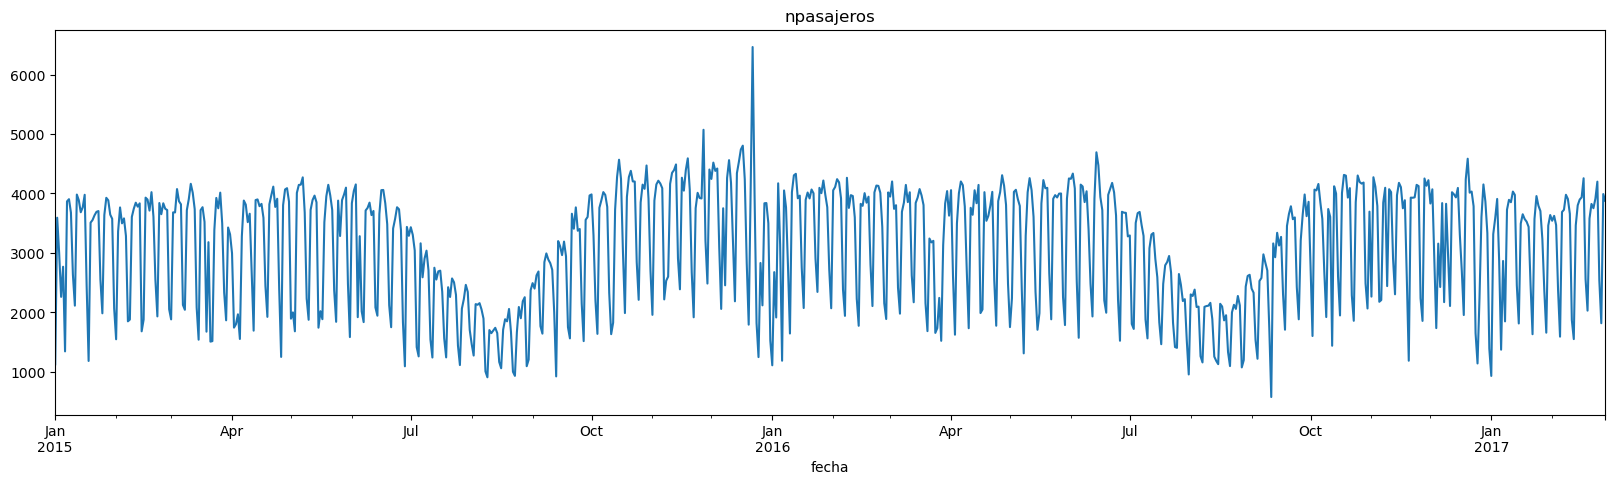

In [159]:
df_numerico.npasajeros.plot(figsize=(20,5), title = "npasajeros")
plt.show() #
#plt.show() lo que hace es eliminar el mensaje que te añade previamente la serie

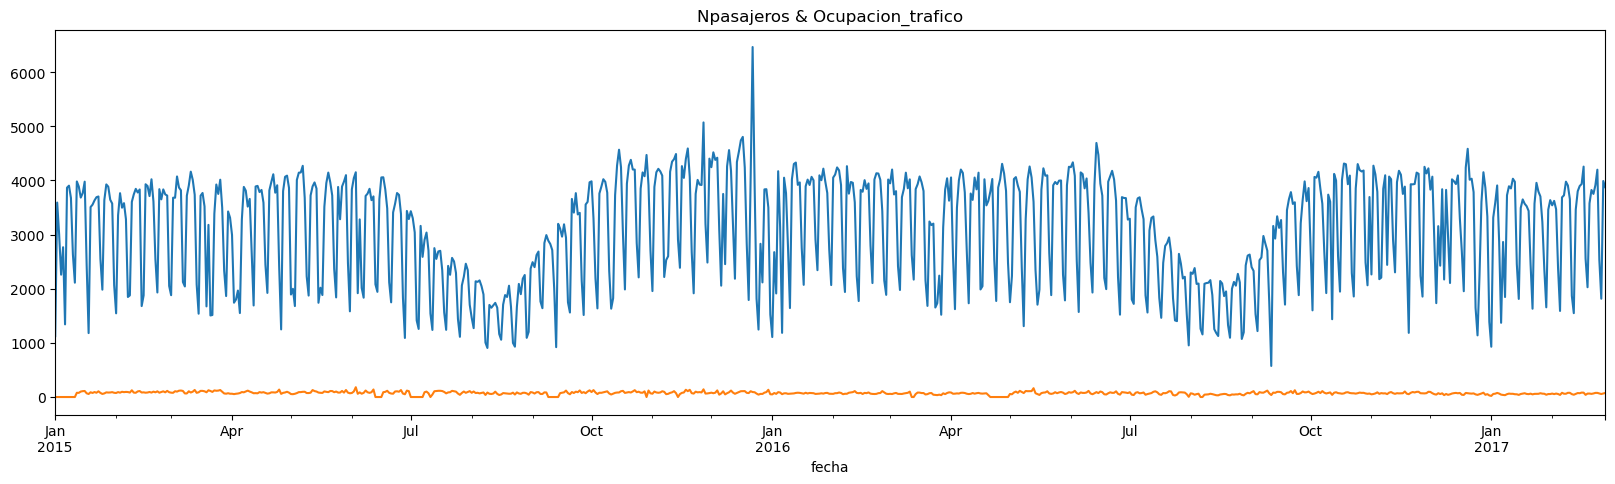

In [160]:
df_numerico.npasajeros.plot(figsize=(20,5), title = "Npasajeros")
df_numerico.ocupacion_trafico.plot(figsize=(20,5), title = "Ocupacion_trafico")
plt.title("Npasajeros & Ocupacion_trafico")
plt.show() 

#### b.2) QQ plot

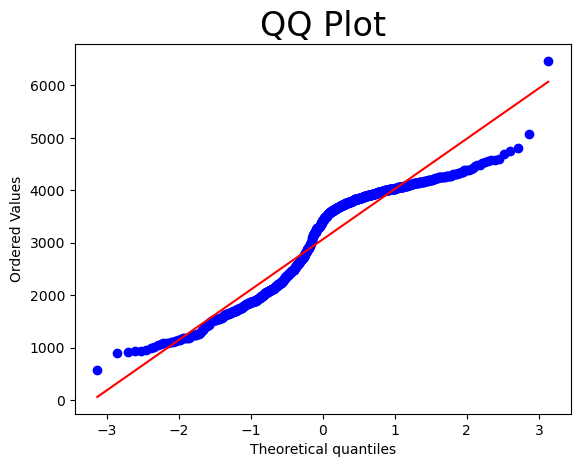

In [161]:
scipy.stats.probplot(df_numerico.npasajeros, plot =  plt) 
#le pasamos la variable que queremos visualizar 
#y el tipo de gráfico (en este caso de matplotlib)
plt.title("QQ Plot", size = 24) #tamaño título del gráfico
plt.show()

Se puede observar perfectamente la tendncia lineal que se traza en el QQ plot.

In [162]:
npasajeros = df_numerico["npasajeros"]

#### b.3) Distribución de la serie temporal

Procedemos a pintar un Histograma para observar la distribución de la variable de estudio `npasajeros`.

C:\Users\amgll\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


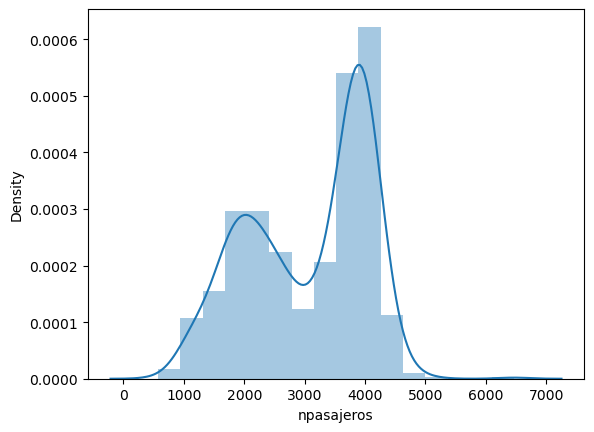

In [163]:
sns.distplot(npasajeros);

# c) Realiza una descomposición de la serie temporal para analizar la tendencia y la estacionalidad. ¿Se trata de una serie estacionaria?

#### c.1) Pintado y división de la serie original

Text(0, 0.5, 'Número de pasajeros')

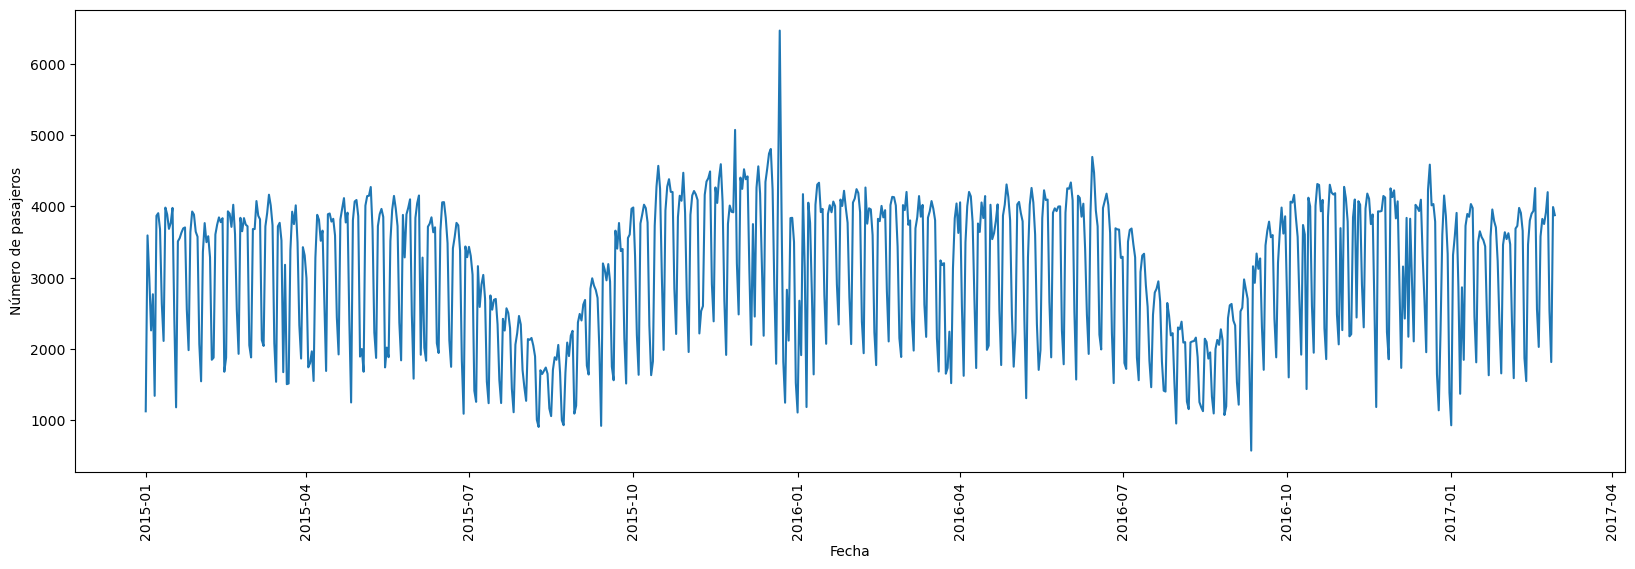

In [164]:
plt.figure(figsize=(20, 6))
plt.plot(npasajeros)
plt.xticks(rotation = 90)
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")

In [165]:
(9000/790)

11.39240506329114

In [166]:
100-11.4

88.6

In [167]:
size = int(len(df_numerico)*0.886)

In [168]:
df_train = df_numerico.iloc[:size]

In [169]:
df_test = df_numerico.iloc[size:]

Text(0, 0.5, 'Número de pasajeros')

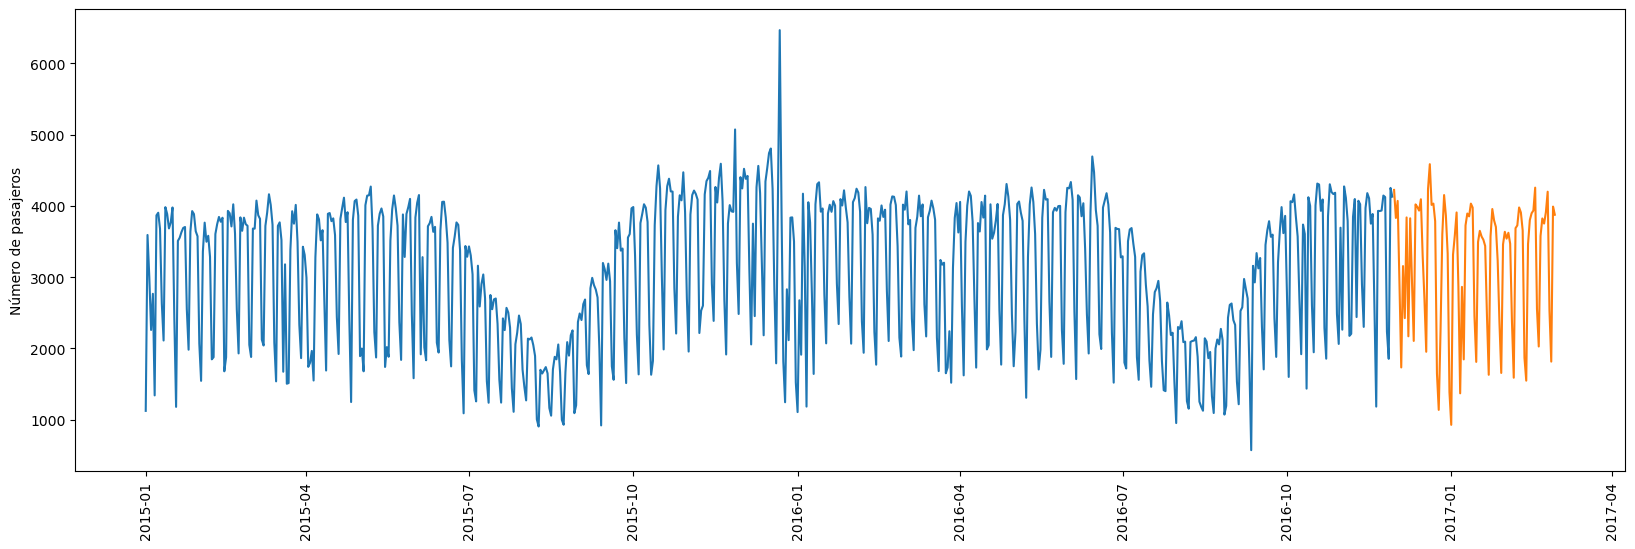

In [170]:
plt.figure(figsize=(20, 6))
plt.plot(df_train.npasajeros)
plt.plot(df_test.npasajeros)
plt.xticks(rotation = 90)
plt.ylabel("Número de pasajeros")

In [171]:
rb = np.random.normal(loc = df_train.npasajeros.mean(), 
                      scale = df_train.npasajeros.std(), 
                      size = len(df_train))
#Size -> Número de datos a crear -> tantos como longitud del dataset
#scale -> desviación estandar de la distribución
#loc -> media de la disttibución

In [172]:
df_train['rb'] = rb

C:\Users\amgll\AppData\Local\Temp\ipykernel_24204\895674884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rb'] = rb


In [173]:
df_train.describe()

,mes,festivo,npasajeros,inten_lluvia,ocupacion_trafico,semana_mes,day_of_week,año,dia_mes,sin_day_of_week,cos_day_of_week,sen_semana_mes,cos_semana_mes,sin_mes,cos_mes,rb
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,6.270386,0.035765,3048.035765,0.476109,73.649143,1.078684,3.001431,2015.477825,15.706724,-0.016073,0.104222,0.668615,0.350629,0.012249,-0.083221,3019.191890
std,3.322213,0.185838,1007.179293,1.813216,28.587949,0.730695,2.002505,0.499866,8.793466,0.668048,0.737569,0.367185,0.543879,0.730165,0.679121,1030.263909
min,1.000000,0.000000,574.000000,0.000000,0.000000,0.000000,0.000000,2015.000000,1.000000,-0.958924,-0.989992,0.000000,-0.416147,-0.999990,-0.989992,-17.061653
25%,3.000000,0.000000,2118.000000,0.000000,60.331301,1.000000,1.000000,2015.000000,8.000000,-0.756802,-0.653644,0.841471,-0.416147,-0.756802,-0.839072,2280.464145
50%,6.000000,0.000000,3338.000000,0.000000,75.894366,1.000000,3.000000,2015.000000,16.000000,0.000000,0.283662,0.841471,0.540302,0.141120,-0.145500,3040.426336
75%,9.000000,0.000000,3926.000000,0.000000,89.820094,2.000000,5.000000,2016.000000,23.000000,0.841471,0.960170,0.909297,0.540302,0.841471,0.540302,3727.954212
max,12.000000,1.000000,6465.000000,17.800000,181.117647,2.000000,6.000000,2016.000000,31.000000,0.909297,1.000000,0.909297,1.000000,0.989358,0.960170,6277.950562


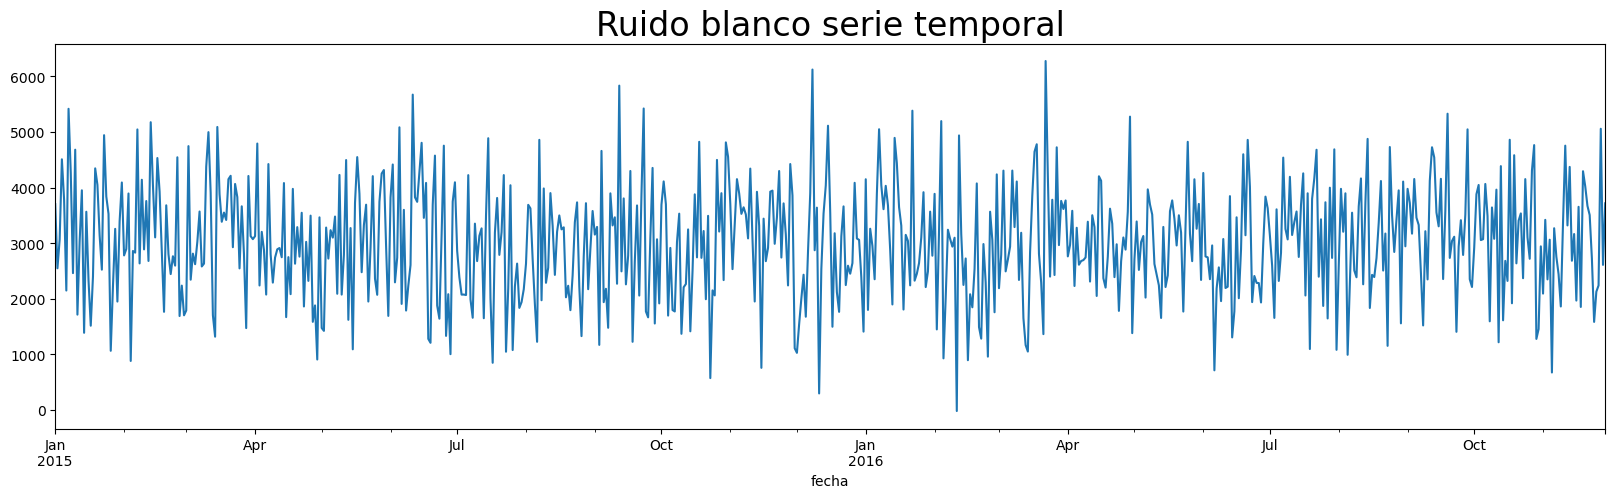

In [174]:
df_train.rb.plot(figsize = (20,5))
plt.title("Ruido blanco serie temporal", size= 24)
plt.show()

#### c.2) Estacionariedad

In [175]:
sts.adfuller(df_train.npasajeros)

(-2.269802042248634,
 0.18189241891137647,
 20,
 678,
 {'1%': -3.4400317565062455,
  '5%': -2.8658123184971576,
  '10%': -2.56904513726821},
 10363.430464349363)

Se puede observar que el valor de Dickey Fuller en el 5% es menor de 0.05 es por lo que se rechaza la hipotesis nula y podemos afirmar que la serie es estacionaria.

#### c.3) Estacionalidad

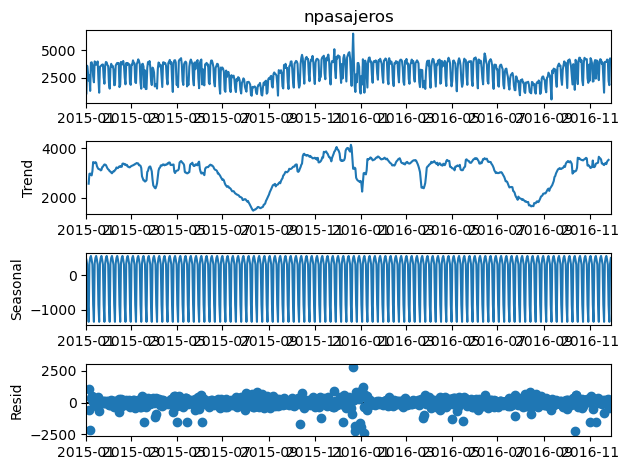

In [176]:
#aplicamos primero aditiva y almacenamos los datos en una variable:
s_dec_additive = seasonal_decompose(df_train.npasajeros, model = "additive")

#visualizamos los datos de la variable:
s_dec_additive.plot()
plt.show()

Tal y como podemos observar en el apartado "Trend", la serie temporal no aumenta su varianza con el paso del tiempo por lo que será __aditiva__ y no multiplicativa.

# d) Determina las transformaciones que hace que la serie sea estacionaria. Recuerda que para ello debes prestar atención a la estacionalidad y la tendencia.

In [177]:
sts.adfuller(s_dec_additive.trend.dropna())

(-2.4412395522243195,
 0.13043343743596503,
 15,
 677,
 {'1%': -3.4400461122487807,
  '5%': -2.8658186431652357,
  '10%': -2.5690485069240654},
 7669.050552477491)

El test de dickey fuller nos aporta un valor p > 0.05, por lo que debemos diferenciar al menos una vez más hasta conseguir que la serie sea estacionaria.

In [178]:
sts.adfuller(s_dec_additive.trend.dropna().diff()[1:])

(-6.2364899867991905,
 4.811513318902543e-08,
 20,
 671,
 {'1%': -3.4401331487581754,
  '5%': -2.865856987951189,
  '10%': -2.569068936347423},
 7642.478243208037)

Después de realizar una diferenciación hemos conseguido un valor menor al p = 0.05 por lo que la serie es estacionaria

# e) Examina el correlograma y correlograma parcial de la serie. Esto te ayudará a seleccionar los parámetros para el modelo que deberás aplicar en el apartado siguiente.

#### e.1) Autocorrelación y autocorrelación parcial (q y p).

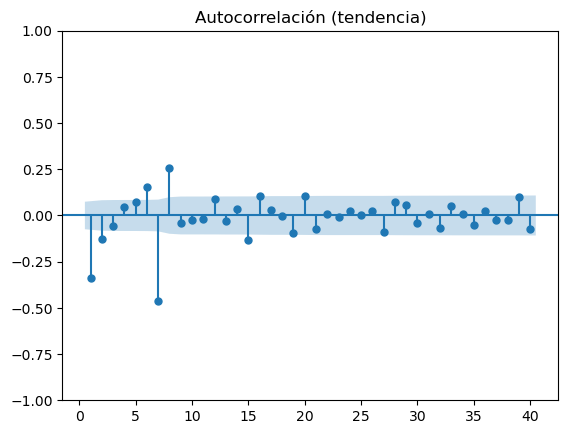

In [179]:
sgt.plot_acf(s_dec_additive.trend.dropna().diff()[1:].diff()[1:], lags = 40, zero = False)
plt.title("Autocorrelación (tendencia)", size = 12)
plt.show()

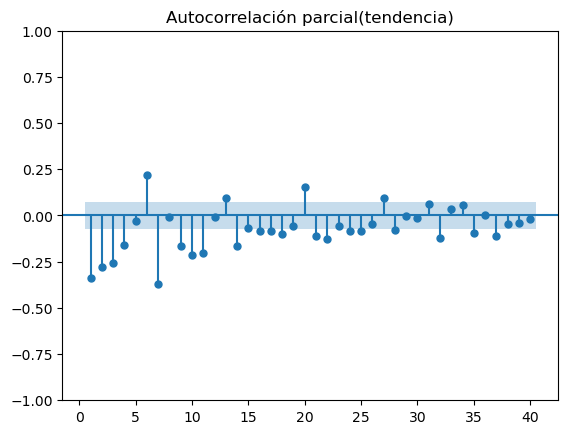

In [180]:
sgt.plot_pacf(s_dec_additive.trend.dropna().diff()[1:].diff()[1:], lags = 40, zero = False, 
              method = ('ols'))
#ols: mínimos cuadrados ordinarios 

plt.title("Autocorrelación parcial(tendencia)",
          size = 12)
plt.show()

#### e.2) Función de autocorrelación (estimamos Q)

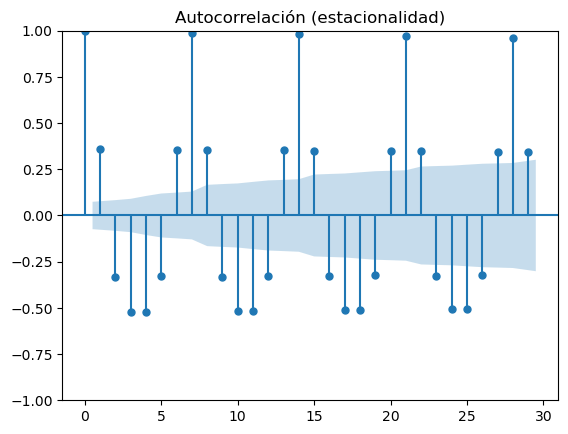

In [181]:
sgt.plot_acf(s_dec_additive.seasonal)
plt.title("Autocorrelación (estacionalidad)", size = 12)
plt.show()

#### e.3) Función de autocorrelación parcial (estimamos P)

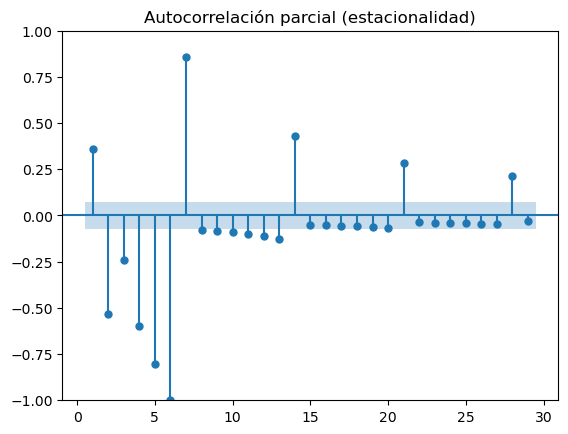

In [182]:
sgt.plot_pacf(s_dec_additive.seasonal, 
              zero = False, 
              method = ('ols'))
plt.title("Autocorrelación parcial (estacionalidad)", size = 12)
plt.show()

#### e.4) Analisis de los residuos de la serie temporal

In [183]:
sts.adfuller(s_dec_additive.resid.dropna())

(-10.937676495814623,
 9.468809042473807e-20,
 20,
 672,
 {'1%': -3.440118534323335,
  '5%': -2.865850549495406,
  '10%': -2.569065506040958},
 9573.72733955227)

C:\Users\amgll\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='resid', ylabel='Density'>

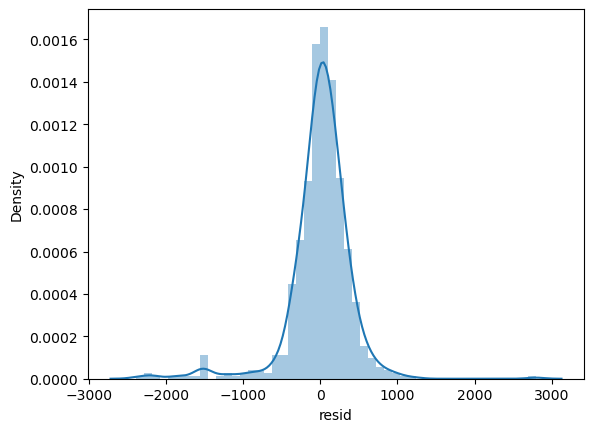

In [184]:
sns.distplot(s_dec_additive.resid.dropna())

# f) Aplica un modelo de series temporales para predecir el número de pasajeros. Para ello divide el dataset en 700 muestras para train y 90 para test.

#### f.1) Ajuste de modelo SARIMAX

In [185]:
y = df_train['npasajeros']
arima_model = auto_arima(y, start_p=0, d=1, start_q=4,
                         max_p=2, max_d=2, max_q=7, start_P=0,
                         D=1, start_Q=0, max_P=5, max_D=5,
                         max_Q=5, m=7, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,4)(0,1,0)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=11089.221, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=10852.738, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=11009.195, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=10803.327, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=10760.907, Time=0.47 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=10753.524, Time=0.72 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=10743.433, Time=1.11 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=4.53 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=2.95 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=10803.320, Time=0.37 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=10691.472, Time=1.45 sec
 ARIMA(2,1,0)(4,1,0)[7]             : AIC=10699.931, Time=0.88 sec
 ARIMA(2,1,0)(5,1,1)[7]             : AIC=i

In [186]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  699
Model:             SARIMAX(2, 1, 1)x(5, 1, [], 7)   Log Likelihood               -5282.509
Date:                            Tue, 05 Sep 2023   AIC                          10583.018
Time:                                    23:29:10   BIC                          10623.861
Sample:                                01-01-2015   HQIC                         10598.816
                                     - 11-29-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2669      0.036      7.314      0.000       0.195       0.338
ar.L2         -0.1238      0.034     -3.636      0.000      -0.190      -0.057
ma.L1         -0.8398      0.033    -25.165      0.000      -0.905      -0.774
ar.S.L7       -0.7244      0.029    -25.237      0.000      -0.781      -0.668
ar.S.L14      -0.5005      0.032    -15.571      0.000      -0.563      -0.437
ar.S.L21      -0.3950      0.043     -9.120      0.000      -0.480      -0.310
ar.S.L28      -0.2219      0.048     -4.664      0.000      -0.315      -0.129
ar.S.L35      -0.1552      0.043     -3.650      0.000      -0.238      -0.072
sigma2      2.536e+05   7406.313     34.238      0.000    2.39e+05    2.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1178.90
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -1.02
Prob(H) (two-sided):                  0.45   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [187]:
modeloSARIMAX = SARIMAX(df_train["npasajeros"], order=(2, 1, 1), 
                        seasonal_order=(5, 1, 0, 7))
modelo = modeloSARIMAX.fit()

C:\Users\amgll\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\amgll\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [188]:
inicio_prediccion = len(df_train["npasajeros"])
fin_prediccion = len(df_test["npasajeros"])
df_test["prediccion"] = modelo.predict(
    start=inicio_prediccion,end=inicio_prediccion + fin_prediccion)

C:\Users\amgll\AppData\Local\Temp\ipykernel_24204\277765702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediccion"] = modelo.predict(


# g) Visualiza el resultado en una gráfica en la que se muestren tanto la serie predicha como la serie real.

Text(0, 0.5, 'Número de pasajeros')

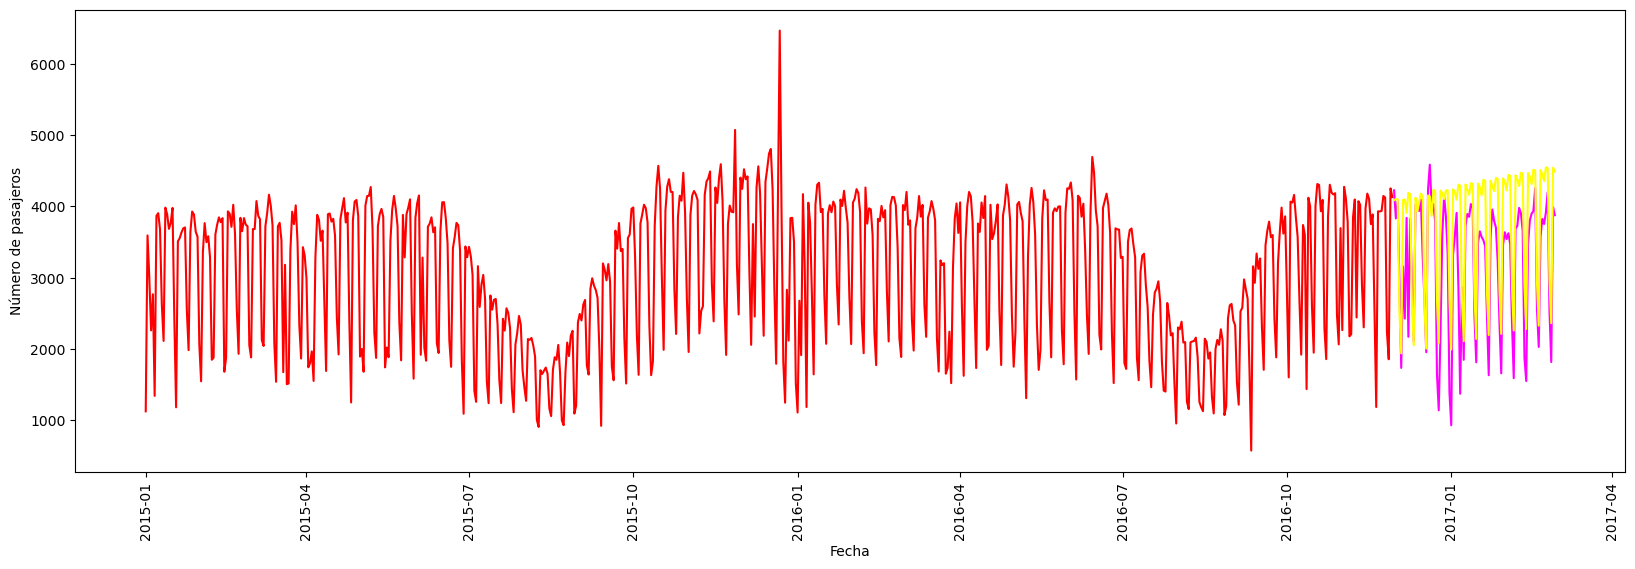

In [189]:
plt.figure(figsize=(20, 6))
plt.plot(df_train["npasajeros"], color = "red")
plt.plot(df_test["npasajeros"], color = "magenta")
plt.plot(df_test["prediccion"], color = "yellow")
plt.xticks(rotation = 90)
plt.xlabel("Fecha")
plt.ylabel("Número de pasajeros")

# h) Utiliza el rmse para medir el resultado de tu modelo.

In [190]:
mse(df_test['npasajeros'], df_test['prediccion'])

574401.5858444733

In [191]:
r2_score(df_test['npasajeros'], df_test['prediccion'])

0.29569630004363123

Observamos que existe en torno a un 29% de variabilidad que el modelo no puede explicar, por lo que procedemos a añadir otras variables exógenas que nos permitan ajustar mejor el modelo.

# i) Trata de mejorar los resultados añadiendo variables exógenas al modelo.

#### i.1) Variables que potencialmente pueden influir en la variable de estudio

In [192]:
matrix_corr = df_train.corr().round(1)

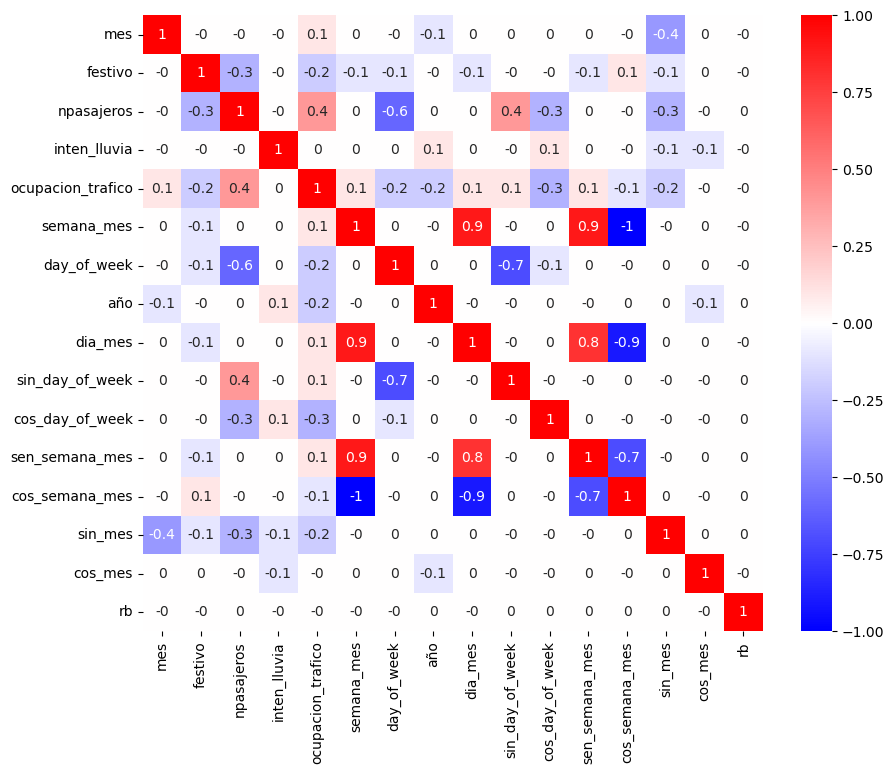

In [193]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(matrix_corr, annot = True, cmap = "bwr", vmax = 1, vmin = -1);

Procedemos a realizar un ranking de variables más correlacionadas con la variable estudio `npasajeros`

In [194]:
# Se hace un ranking de variables más correlacionadas con el target
# (en valor absoluto) a menos correlacionadas:
matrix_corr['npasajeros'].abs().sort_values()[::-1]

npasajeros           1.0
day_of_week          0.6
sin_day_of_week      0.4
ocupacion_trafico    0.4
sin_mes              0.3
cos_day_of_week      0.3
festivo              0.3
rb                   0.0
cos_mes              0.0
cos_semana_mes       0.0
sen_semana_mes       0.0
dia_mes              0.0
año                  0.0
semana_mes           0.0
inten_lluvia         0.0
mes                  0.0
Name: npasajeros, dtype: float64

In [195]:
variables_exogenas = ["day_of_week", "sin_day_of_week", "sin_day_of_week", "ocupacion_trafico", "sin_mes", "cos_day_of_week", "festivo"]

In [196]:
print(variables_exogenas)

['day_of_week', 'sin_day_of_week', 'sin_day_of_week', 'ocupacion_trafico', 'sin_mes', 'cos_day_of_week', 'festivo']


#### i.2) Modelo de predicción incluyendo las variables exógenas

In [197]:
X = df_train.drop("npasajeros", axis = 1)
y = df_train["npasajeros"]

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.114, random_state = 0)

In [199]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Tal y como hemos observado abteriormente, se trata de una distribución lineal, por lo que tlizaremos una regresión lineal. Además, procedemos a utilizar `SequentialFeatureSelector` para determianr la mejor combinación de variables según R2.

In [200]:
sbs = SFS(LinearRegression(),k_features=7,forward=False,floating=False)
sbs.fit(np.array(X_train), y_train)

SequentialFeatureSelector(estimator=LinearRegression(), forward=False,
                          k_features=(7, 7), scoring='r2')

In [201]:
sbs.k_feature_names_

('0', '1', '3', '5', '6', '9', '12')

In [202]:
[X.columns[int(index)] for index in list(sbs.k_feature_idx_)]

['mes',
 'festivo',
 'ocupacion_trafico',
 'day_of_week',
 'año',
 'cos_day_of_week',
 'sin_mes']

In [203]:
#X = dataset[[X.columns[int(index)] for index in list(sbs.k_feature_idx_)]]
#y = dataset['npasajeros']

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.114, random_state = 0)

In [205]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [206]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [207]:
y_pred = regression.predict(X_test)

In [208]:
r2 = regression.score(X_test, y_test)
r2

0.7353344985434453

Introduciendo todas las variables exógenas obtenemos de base una mejoría, pero queremos observar la combinación más idonea para ajustar el modelo.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.114, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(619, 15)
(80, 15)
(619,)
(80,)


In [211]:
X = df_numerico.drop("npasajeros", axis = 1)
Y = df_numerico['npasajeros']

In [212]:
X_train_df = pd.DataFrame(X_train, columns = X.columns)
X_test_df = pd.DataFrame(X_test, columns = X.columns)

In [213]:
dataset_seleccion.sort_values(by = "r2", ascending = False, ignore_index = True)

,variables,r2
0,"[mes, festivo, inten_lluvia, ocupacion_trafico...",0.753226
1,"[mes, festivo, inten_lluvia, ocupacion_trafico...",0.751780
2,"[mes, festivo, inten_lluvia, ocupacion_trafico...",0.748883
3,"[mes, festivo, inten_lluvia, ocupacion_trafico...",0.748865
4,"[mes, festivo, inten_lluvia, ocupacion_trafico...",0.748865
5,"[mes, festivo, ocupacion_trafico, day_of_week,...",0.747982
6,"[mes, festivo, day_of_week, cos_day_of_week, s...",0.745776
7,"[festivo, day_of_week, cos_day_of_week, sin_mes]",0.725678
8,"[day_of_week, cos_day_of_week, sin_mes]",0.579292
9,"[day_of_week, cos_day_of_week]",0.466405


In [214]:
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [215]:
# model evaluation for training set

y_train_predict = regression.predict(X_train)
rmse = mean_squared_error(y_train, y_train_predict, squared = False)
r2 = r2_score(y_train, y_train_predict)


print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set

y_test_predict = regression.predict(X_test)
# root mean square error of the model
rmse = mean_squared_error(y_test, y_test_predict, squared = False)

# r-squared score of the model
r2 = r2_score(y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 514.3553264897422
R2 score is 0.7368220514714894


The model performance for testing set
--------------------------------------
RMSE is 511.3546153334286
R2 score is 0.7562000616905822


Una vez añadidas las variables exógenas correctas hemos conseguido explicar en torno 4.5% de los desajustes del modelo, obteniendo un porcentaje de desajuste final de 24.4% 

---FIN DEL EJERCICIO---